In [1]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [19]:
import numpy as np
import pylab

import nengo
import nengolib
print nengolib.__file__


c:\users\aaron\ctn\nengolib\nengolib\__init__.pyc


In [107]:

from nengo.base import Process
from nengo.params import ValidationError
from nengo.dists import Choice, Distribution
from nengo.utils.stdlib import checked_call


from nengolib.signal import LinearSystem


class SystemEvalPoints(Distribution):
    """Samples from the state of a LinearSystem given some process / callable."""

    def __init__(self, sys, callable_or_process, n_steps=10000, dt=None, **run_steps_kwargs):
        super(SystemEvalPoints, self).__init__()
        self.sys = LinearSystem(sys)
        if not isinstance(callable_or_process, Process):
            callable_or_process = CallableProcess(callable_or_process)
        self.process = callable_or_process
        self.n_steps = n_steps
        if dt is None:
            dt = self.process.default_dt  # 0.001
        self.dt = dt
        self.run_steps_kwargs = run_steps_kwargs

    def __repr__(self):
        return "%s(sys=%r, callable_or_process=%r, n_steps=%r, dt=%r, **%r)" % (
            type(self).__name__, self.sys, self.process, self.n_steps, self.dt, self.run_steps_kwargs)

    def _sample(self, d, rng):
        if self.sys.size_out != d:
            raise ValidationError(
                "sys.size_out (%d) must equal sample d (%s)" % (self.sys.size_out, d),
                attr='sys', obj=self)
        u = self.process.run_steps(
            self.n_steps, d=self.sys.size_in, dt=self.dt, rng=rng, **self.run_steps_kwargs)
        return self.sys.filt(u, dt=self.dt)
    
    def sample(self, num, d=1, rng=np.random):
        y = self._sample(d, rng)
        choices = rng.choice(len(y), size=num, replace=True)
        return y[choices]

    
class SystemEncoders(SystemEvalPoints):
    """Encoders sampled from the maximum radii of a filtered process / callable."""

    def sample(self, num, d=1, rng=np.random):
        y = self._sample(d, rng)
        r = np.max(np.abs(y), axis=0)
        assert r.shape == (d,)
        rI = r*np.eye(d)
        return Choice(np.vstack([rI, -rI])).sample(num, d=d, rng=rng)
        

class CallableProcess(Process):
    """Callable adapted to behave as a Process."""

    def __init__(self, func, default_size_out=None):
        self.func = func
        if default_size_out is None:
            value, invoked = checked_call(func, 0.)
            if not invoked:
                raise ValidationError(
                    "function (%s) must only take single float argument" % func,
                    attr='func', obj=self)
            default_size_out = np.asarray(value).size
        super(CallableProcess, self).__init__(default_size_out=default_size_out)

    def __repr__(self):
        return "%s(func=%r, default_size_out=%r)" % (
            type(self).__name__, self.func, self.default_size_out)
        
    def make_step(self, shape_in, shape_out, dt, rng):
        if shape_in != (0,):
            raise ValidationError("shape_in must be (0,), got %s" % (
                shape_in,), attr='func', obj=self)
        if shape_out != (self.default_size_out,):
            raise ValidationError("shape_out must be (%s,), got %s" % (
                self.default_size_out, shape_out), atr='func', obj=self)
        def step(t):
            return self.func(t)
        return step
    
'''

class ProcessDistribution(Distribution):
    """Samples from running a process."""

    def __init__(self, process, n_steps=10000, dt=None, **run_steps_kwargs):
        super(ProcessDistribution, self).__init__()
        self.process = process
        self.n_steps = n_steps
        if dt is None:
            dt = process.default_dt  # 0.001
        self.dt = dt
        self.run_steps_kwargs = run_steps_kwargs

    def __repr__(self):
        return "%s(process=%r, n_steps=%r)" % (
            type(self).__name__, self.process, self.n_steps)

    def sample(self, num, d=1, rng=np.random):
        num, d = self._sample_shape(num, d)
        output = self.process.run_steps(
            self.n_steps, d=d, dt=self.dt, rng=rng, **self.run_steps_kwargs)
        choices = rng.choice(len(output), size=num, replace=True)
        return output[choices]
'''

'\n\nclass ProcessDistribution(Distribution):\n    """Samples from running a process."""\n\n    def __init__(self, process, n_steps=10000, dt=None, **run_steps_kwargs):\n        super(ProcessDistribution, self).__init__()\n        self.process = process\n        self.n_steps = n_steps\n        if dt is None:\n            dt = process.default_dt  # 0.001\n        self.dt = dt\n        self.run_steps_kwargs = run_steps_kwargs\n\n    def __repr__(self):\n        return "%s(process=%r, n_steps=%r)" % (\n            type(self).__name__, self.process, self.n_steps)\n\n    def sample(self, num, d=1, rng=np.random):\n        num, d = self._sample_shape(num, d)\n        output = self.process.run_steps(\n            self.n_steps, d=d, dt=self.dt, rng=rng, **self.run_steps_kwargs)\n        choices = rng.choice(len(output), size=num, replace=True)\n        return output[choices]\n'

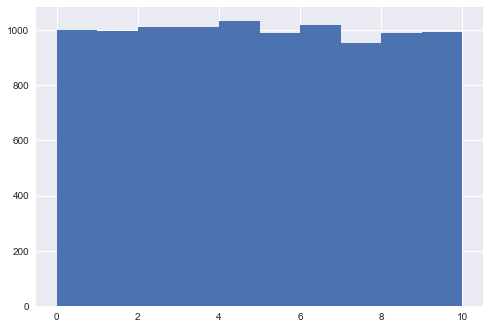

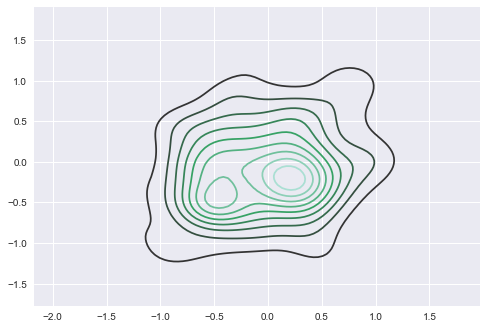

In [93]:
rng = np.random.RandomState(0)

pylab.figure()
pylab.hist(ProcessDistribution(CallableProcess(lambda t: t)).sample(10000, rng=rng).squeeze())
pylab.show()

pylab.figure()
sns.kdeplot(ProcessDistribution(nengo.processes.WhiteSignal(100.0, high=10, seed=0)).sample(100, 2, rng=rng))
pylab.show()

SystemEvalPoints(sys=LinearSystem(sys=(array([[-20., -100.],
       [  1.,   0.]]), array([[ 1.],
       [ 0.]]), array([[ 1.,  0.],
       [ 0.,  1.]]), array([[ 0.],
       [ 0.]])), analog=True), callable_or_process=WhiteSignal(period=100.0, high=10, rms=0.5), n_steps=10000, dt=0.001, **{})


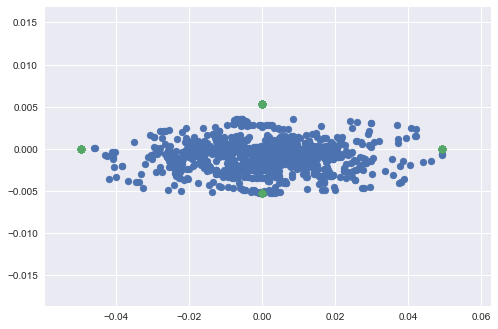

In [110]:
sys = nengolib.Alpha(0.1).X
# process = lambda t: 1000 if t <= 0.001 else 0
process = nengo.processes.WhiteSignal(100.0, high=10, seed=0)

n = 1000
dist = SystemEvalPoints(sys, process)
eval_points = dist.sample(n, len(sys))

print repr(dist)

encoders = SystemEncoders(sys, process).sample(n, len(sys))

pylab.figure()
pylab.scatter(*eval_points.T)
pylab.scatter(*encoders.T)
pylab.show()